# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Determine the diffraction shifts
4. **Calculate lattice vectors**
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 4: Calculate lattice vectors

In this step the lattice vectors are calculated from the list of Bragg peaks, as follows:

* For one, typical diffraction pattern:
    * Get the list of Bragg peaks
    * Calculate the projection of the peak lists as a function of rotation, from 0 to 180 degrees
    * Find rotation angles that give the fewest, sharpest projected peaks
    * Get the lattice vectors
* Save the lattice vector list

### Import packages, load data

In [35]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import RectBivariateSpline
from time import time

from py4DSTEM.process.datastructure import PointList

In [5]:
# Load the raw data
fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
dc = py4DSTEM.readwrite.read_data(fp)
dc.set_scan_shape(60,60)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# Load corrected Bragg peaks list
fp_Braggpeaks = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
browser.show_dataobjects()
Bragg_peaks = browser.get_dataobject(0)

# Load the deconvolution
fp_deconvolution = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_deconvolution)
browser.show_dataobjects()
deconvolution = browser.get_dataobject(0)

Reading file /Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3...

/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3 is not a py4DSTEM file.  Reading with hyperspy...
 Index                  Name                        Type        
   0    shifted_Braggpeaks                  PointListArray      
 Index                  Name                        Type        
   0    diffractionslice_0                  DiffractionSlice    


In [6]:
# # Load the raw data
# fp = "/home/ben/Data/20180905_FePO4_unlithiated/raw/Stack1_57x47+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm4"
# dc = py4DSTEM.readwrite.read_data(fp)
# dc.set_scan_shape(47,57)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

# # Load corrected Bragg peaks list
# fp_Braggpeaks = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks__shift_corrected.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_Braggpeaks)
# browser.show_dataobjects()
# Bragg_peaks = browser.get_dataobject(0)

# # Load the deconvolution
# fp_deconvolution = "/home/ben/Data/20180905_FePO4_unlithiated/processing/deconvolution.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_deconvolution)
# browser.show_dataobjects()
# deconvolution = browser.get_dataobject(0)

### Take radon transform of average deconvolution

#### Calculating the Radon transform using the Central Slice Theorem

Let $f(x,y)$ be some real valued function in two dimensions, $\mathcal{F}_2 f(k_x,k_y)$ be its two dimensional Fourier transform, $\mathcal{R}f(r,\theta)$ be its Radon transform, and $\mathcal{F}_r(\mathcal{R}f)(k,\theta)$ be the one dimensional Fourier transform of $\mathcal{R}f$ along its first (non-angle) coordinate.  Then the Central Slice Theorem states:

\begin{equation}
\mathcal{F}_2 f(R\cos\theta,R\sin\theta) = \mathcal{F}_r(\mathcal{R}f)(R,\theta)
\end{equation}

Qualitative, this says: a one dimensional slice through the center of the two-dimensional Fourier transform of $f$ along a line at angle $\theta$ is equal to the one-dimensional Fourier transform along the position coordinate of the Radon transform of $f$, evaluated at angle $\theta$.

Algorithmically, this means we can calculate the Radon transform by taking a two-dimensional Fourier transform, extracting 1D slices through its center, then inverse Fourier transforming.

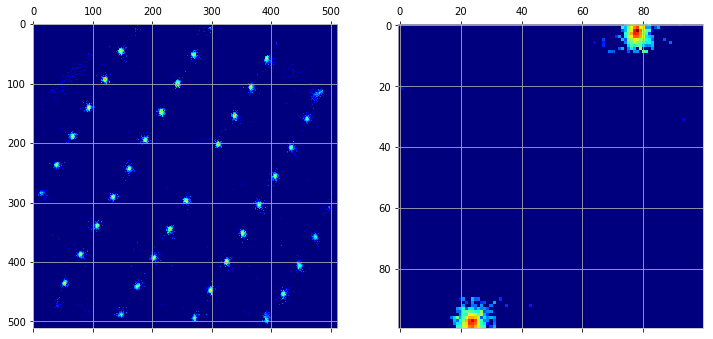

In [92]:
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(deconvolution.data2D,sigma=2)),(dc.Q_Nx,dc.Q_Ny))

deconvolution.data2D[x0-40:x0+40,y0-40:y0+40] = 0

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
ax1.matshow(deconvolution.data2D**power,cmap='jet')
ax2.matshow(deconvolution.data2D[x0-50:x0+50,y0-50:y0+50]**power,cmap='jet')
plt.show()

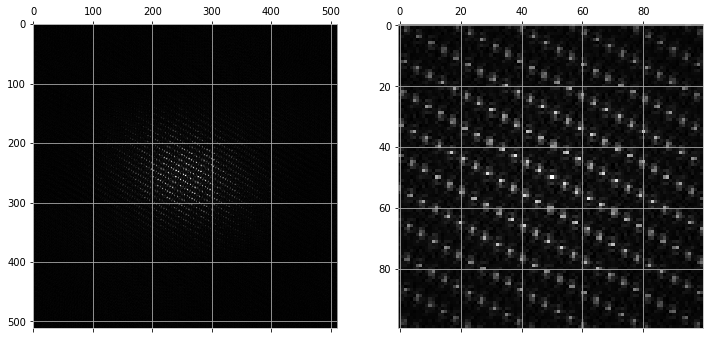

In [93]:
# Get FFT

fft = np.fft.fft2(deconvolution.data2D)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(np.fft.fftshift(np.abs(fft)))
ax2.matshow(np.fft.fftshift(np.abs(fft))[int(fft.shape[0]/2-50):int(fft.shape[0]/2+50),int(fft.shape[1]/2-50):int(fft.shape[1]/2+50)])
plt.show()

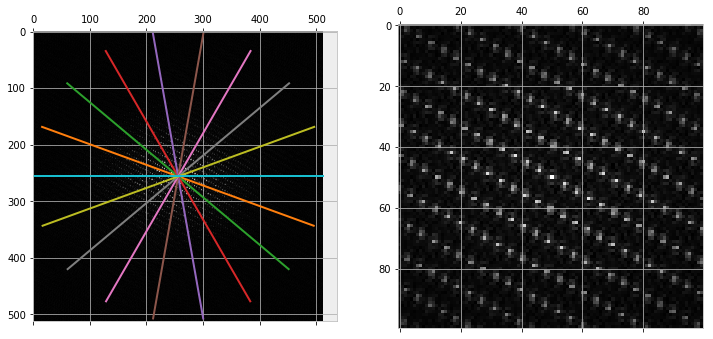

In [94]:
# Get center and slices

kx0,ky0 = fft.shape[0]/2,fft.shape[1]/2
thetas = np.linspace(0,np.pi,10)
k = np.arange(-int(fft.shape[0]/2),int(fft.shape[0]/2))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(np.fft.fftshift(np.abs(fft)))
ax2.matshow(np.fft.fftshift(np.abs(fft))[int(fft.shape[0]/2-50):int(fft.shape[0]/2+50),int(fft.shape[1]/2-50):int(fft.shape[1]/2+50)])

for theta in thetas:
    cost, sint = np.cos(theta), np.sin(theta)
    lx = k*cost+kx0
    ly = k*sint+ky0
    ax1.plot(lx,ly)
plt.show()

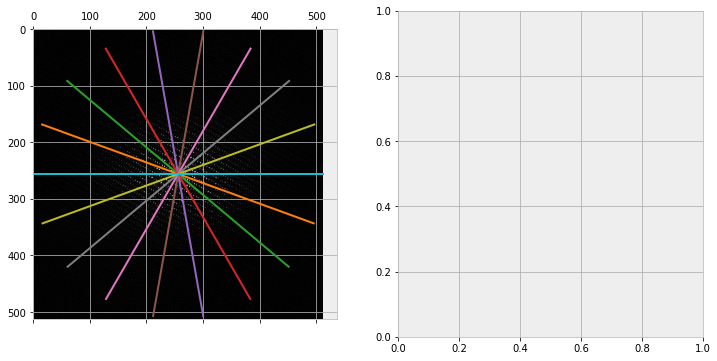

In [95]:
# Interpolate values along slices

kx0,ky0 = fft.shape[0]/2,fft.shape[1]/2
thetas = np.linspace(0,np.pi,10)
k = np.arange(-int(fft.shape[0]/2),int(fft.shape[0]/2))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(np.fft.fftshift(np.abs(fft)))
for theta in thetas:
    cost, sint = np.cos(theta), np.sin(theta)
    lx = k*cost+kx0
    ly = k*sint+ky0
    ax1.plot(lx,ly)
    

plt.show()

In [96]:
realSpline = RectBivariateSpline(np.arange(fft.shape[0]),np.arange(fft.shape[1]),np.fft.fftshift(np.real(fft)))
imagSpline = RectBivariateSpline(np.arange(fft.shape[0]),np.arange(fft.shape[1]),np.fft.fftshift(np.imag(fft)))

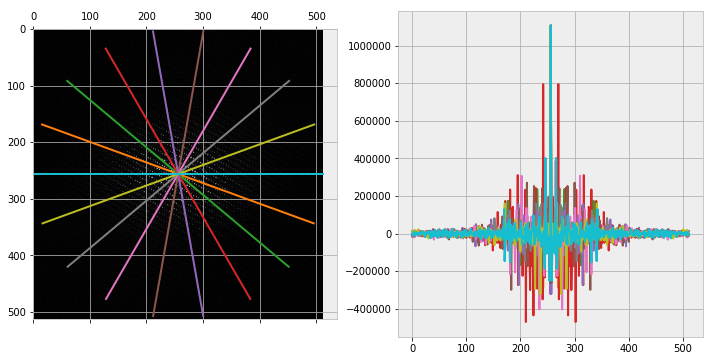

In [97]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(np.fft.fftshift(np.abs(fft)))

for theta in thetas:
    cost, sint = np.cos(theta), np.sin(theta)
    lx = k*cost+kx0
    ly = k*sint+ky0
    ax1.plot(lx,ly)

    real = realSpline.__call__(lx,ly,grid=False)
    imag = imagSpline.__call__(lx,ly,grid=False)
    
    ax2.plot(np.arange(len(real)),real)
    
plt.show()

In [98]:
thetas = np.linspace(0,np.pi,500)
kx0,ky0 = fft.shape[0]/2,fft.shape[1]/2
k = np.arange(-int(fft.shape[0]/2),int(fft.shape[0]/2))

sinogram = np.zeros((len(k),len(thetas)),dtype=complex)    

for i in range(len(thetas)):
    theta = thetas[i]
    
    cost, sint = np.cos(theta), np.sin(theta)
    lx = k*cost+kx0
    ly = k*sint+ky0
    ax1.plot(lx,ly)

    real = realSpline.__call__(lx,ly,grid=False)
    imag = imagSpline.__call__(lx,ly,grid=False)

    sinogram[:,i] = np.fft.ifft(np.fft.fftshift(real + 1j*imag))

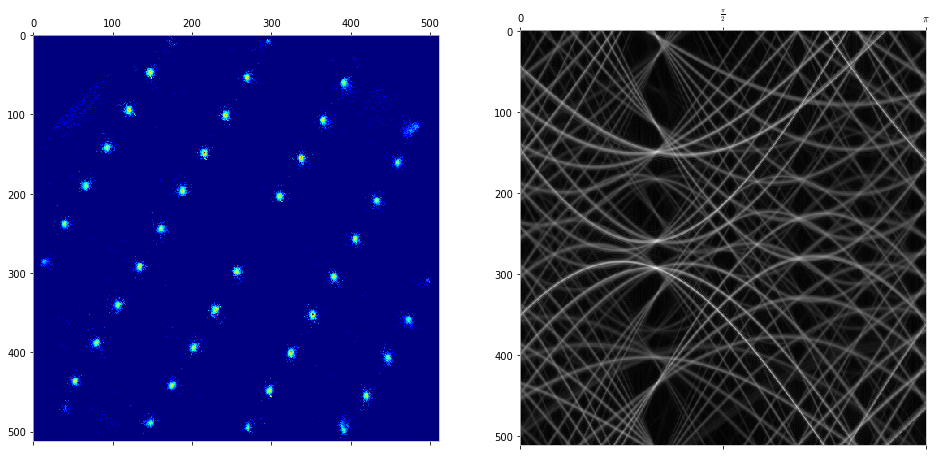

In [101]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(deconvolution.data2D**power,cmap='jet')
ax2.matshow(np.abs(sinogram)**0.5)
ax2.set_xticks([0,len(thetas)/2,len(thetas)])
ax2.set_xticklabels(['0',r'$\frac{\pi}{2}$',r'$\pi$'])
ax1.grid(False)
ax2.grid(False)
plt.show()

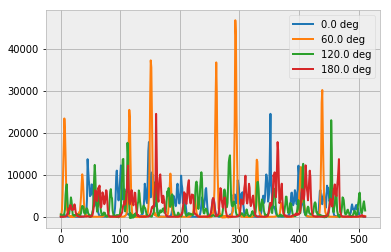

In [115]:
fig,ax=plt.subplots()
for theta in np.linspace(0,np.pi,4):
    ind = np.argmin(np.abs(thetas-theta))
    ax.plot(np.arange(len(sinogram[:,ind])),np.real(sinogram[:,ind]),label='{:.4} deg'.format(180*theta/np.pi))
plt.legend()
plt.show()

In [114]:
118.8/180

0.66

### Get the list of Bragg peaks

In [5]:
# Select DP, get the Bragg peaks for this DP

rx,ry = 25,25
Bragg_peaks_current_DP = Bragg_peaks.get_pointlist(rx,ry)

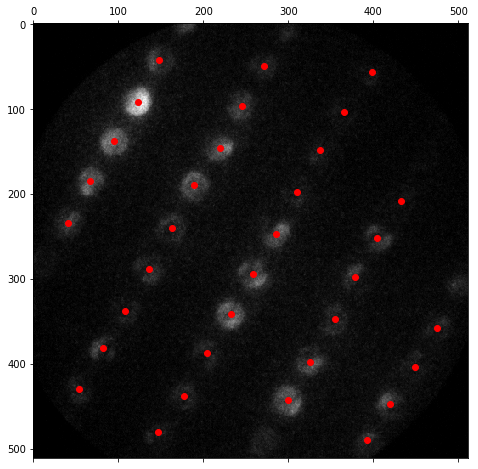

In [6]:
# Show

DP = dc.data4D[rx,ry,:,:]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
plt.show()

### Rotate, calculate projection, get projection maxima

In [7]:
# Get rotated coordinates

rotation_degrees = 30

theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

Bragg_peaks_rotated = Bragg_peaks_current_DP.copy()

for i in range(Bragg_peaks_current_DP.length):
    x0 = Bragg_peaks_current_DP.data['qx'][i]
    y0 = Bragg_peaks_current_DP.data['qy'][i]
    Bragg_peaks_rotated.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotated.data['qy'][i] = x0*sintheta + y0*costheta

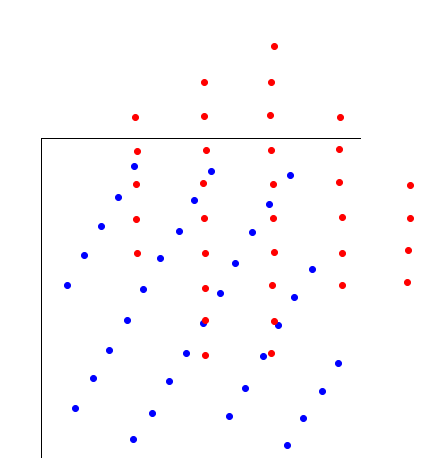

In [8]:
# Show

axis=np.ones_like(DP)
axis[0,:]=0
axis[:,0]=0

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(axis)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='b')
ax.scatter(Bragg_peaks_rotated.data['qy'],Bragg_peaks_rotated.data['qx'],color='r')
ax.axis('off')
plt.show()

In [9]:
# Calculate projected histograms

sigma_gaussianblur = 10

bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
projected_histogram = np.zeros_like(bins)
for i in range(Bragg_peaks_rotated.length):
    projected_histogram[int(Bragg_peaks_rotated.data['qx'][i])] += 1

histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)

In [10]:
# Get histogram maxima

min_dist = 10

maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))

coordinates = [('bin',int),('intensity',float)]
maxima = PointList(coordinates, dc)

for i in maxima0.nonzero()[0]:
    new_point = (bins[i], histogram_blurred[i])
    maxima.add_point(new_point)

maxima.sort('intensity')

deletemask = np.zeros(maxima.length,dtype=bool)
for i in range(maxima.length):
    if not deletemask[i]:
        delete = np.abs(maxima.data['bin'][i]-maxima.data['bin']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
maxima.remove_points(deletemask)


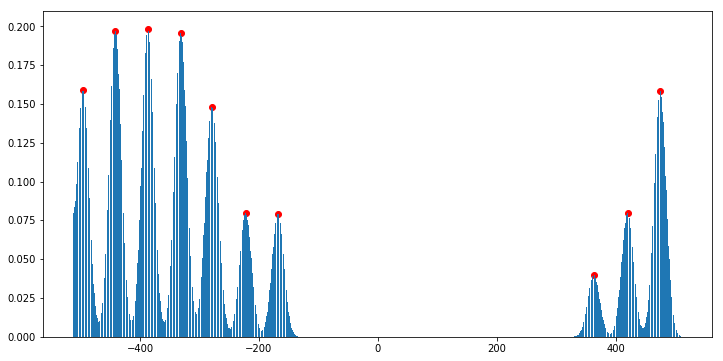

In [11]:
# Plot histograms

fig,ax = plt.subplots(figsize=(12,6))
ax.bar(bins, histogram_blurred)
ax.scatter(maxima.data['bin'],maxima.data['intensity'],color='r')
plt.show()

### Calculate the projection of the peaks as a function of rotation, from 0 to 180 degrees

In [12]:
# As a function of rotation angle, find number and intensity of histogram maxima

sigma_gaussianblur = 10
min_dist = 10
N_rotations = 100
threshhold = 0.05

# Rotating peaks list
Bragg_peaks_rotating = Bragg_peaks_current_DP.copy()
rotation_degrees = 180./N_rotations
angles = np.linspace(0,180,N_rotations,endpoint=False)
theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

# Metrics
N_maxima = np.empty_like(angles)
total_intensity = np.empty_like(angles)

t0=time()
for j in range(len(angles)):
    angle = angles[j]
    
    # Rotate peaks
    for i in range(Bragg_peaks_rotating.length):
        x0 = Bragg_peaks_rotating.data['qx'][i]
        y0 = Bragg_peaks_rotating.data['qy'][i]
        Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
        Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
    # Get projected histogram
    bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
    projected_histogram = np.zeros_like(bins)
    for i in range(Bragg_peaks_rotating.length):
        projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1
        
    histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)
    
    # Get maxima
    maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))
    
    coordinates = [('angle',float),('bin',int),('intensity',float)]
    maxima = PointList(coordinates, dc)
 
    for i in maxima0.nonzero()[0]:
        new_point = (angle, bins[i], histogram_blurred[i])
        maxima.add_point(new_point)
        
    maxima.sort('intensity')

    # Remove maxima below threshhold
    max_intensity = maxima.data['intensity'][0]
    deletemask = np.zeros(maxima.length,dtype=bool)
    for i in range(maxima.length):
        if maxima.data['intensity'][i]/max_intensity < threshhold:
            deletemask[i] = True
    maxima.remove_points(deletemask)
        
    # Remove maxima which are too close together
    deletemask = np.zeros(maxima.length,dtype=bool)
    for i in range(maxima.length):
        if not deletemask[i]:
            delete = np.abs(maxima.data['bin'][i]-maxima.data['bin']) < min_dist
            delete[:i+1]=False
            deletemask = deletemask | delete
    maxima.remove_points(deletemask)
    
    # Calculat metrics
    N_maxima[j] = maxima.length
    total_intensity[j] = np.sum(maxima.data['intensity'])

t=time()-t0
print("Time elapsed: {}h {}m {}s".format(int(t/3600),int(t/60)%60,int(t)%60))

Time elapsed: 0h 0m 0s


### Get initial guess at u and v angles

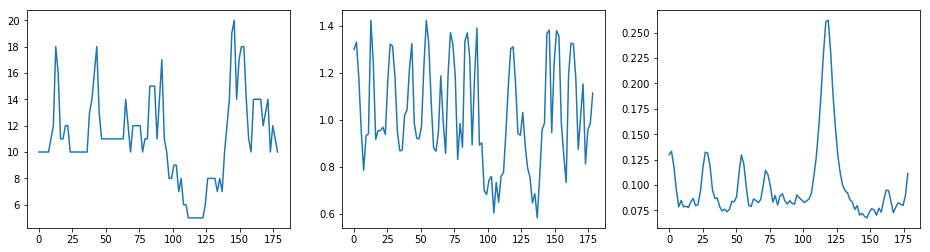

In [13]:
# Plot results. 
# Number of maxima, total intensity of maxima, and score (inten/#) function

score = total_intensity/N_maxima

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
ax1.plot(angles,N_maxima)
ax2.plot(angles,total_intensity)
ax3.plot(angles,score)
plt.show()

In [14]:
# Get maxima of scores

sigma = 2
min_diff = 5

score_blurred = gaussian_filter(score,sigma)

score_maxima0 = (score_blurred > np.roll(score_blurred,-1)) & (score_blurred >= np.roll(score_blurred,+1))

coordinates = [('angle',float),('intensity',float)]
score_maxima = PointList(coordinates, dc)

for i in score_maxima0.nonzero()[0]:
    new_point = (angles[i], score_blurred[i])
    score_maxima.add_point(new_point)

score_maxima.sort('intensity')

deletemask = np.zeros(score_maxima.length,dtype=bool)
for i in range(score_maxima.length):
    if not deletemask[i]:
        delete = np.abs(score_maxima.data['angle'][i]-score_maxima.data['angle']) < min_diff
        delete[:i+1]=False
        deletemask = deletemask | delete
score_maxima.remove_points(deletemask)

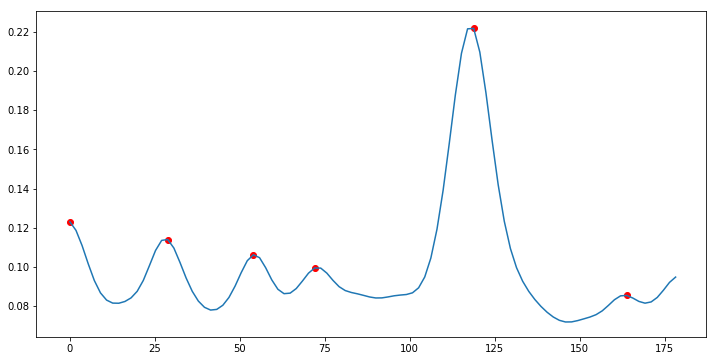

In [15]:
# Plot score and maxima

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(angles, score_blurred)
ax.scatter(score_maxima.data['angle'],score_maxima.data['intensity'],color='r')
plt.show()

In [16]:
# Get initial guess at u angle

score_maxima.sort('intensity')
u_angle0 = score_maxima.data['angle'][0]

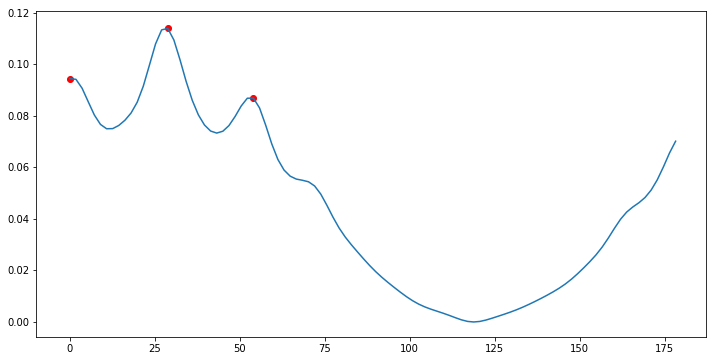

In [17]:
# Damp scores by cosine envelope about the u angle
# Get maxima, plot

sigma = 2
min_diff = 5

score_sin_damped = score_blurred*np.sin((angles-u_angle0)*np.pi/180.)**2

score_maxima0 = (score_sin_damped > np.roll(score_sin_damped,-1)) & (score_sin_damped >= np.roll(score_sin_damped,+1))

coordinates = [('angle',float),('intensity',float)]
score_maxima = PointList(coordinates, dc)

for i in score_maxima0.nonzero()[0]:
    new_point = (angles[i], score_sin_damped[i])
    score_maxima.add_point(new_point)

score_maxima.sort('intensity')

deletemask = np.zeros(score_maxima.length,dtype=bool)
for i in range(score_maxima.length):
    if not deletemask[i]:
        delete = np.abs(score_maxima.data['angle'][i]-score_maxima.data['angle']) < min_diff
        delete[:i+1]=False
        deletemask = deletemask | delete
score_maxima.remove_points(deletemask)

# Plot
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(angles, score_sin_damped)
ax.scatter(score_maxima.data['angle'],score_maxima.data['intensity'],color='r')
plt.show()

In [18]:
# Get initial guess at u angle

score_maxima.sort('intensity')
v_angle0 = score_maxima.data['angle'][0]

In [19]:
print("Initial guess at u and v angles is {} and {}, respectively.".format(u_angle0,v_angle0))

Initial guess at u and v angles is 118.8 and 28.8, respectively.


### Refinement

In [22]:
# Refine the u and v angles

# Params for refinement angles
window_rad_degrees = 8
N_rotations = 50

# Params for histograms
sigma_gaussianblur = 10
min_dist = 10
threshhold = 0.05

angles = np.linspace(-window_rad_degrees,window_rad_degrees,N_rotations)
rotation_degrees = 2*window_rad_degrees/N_rotations
theta = rotation_degrees*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)

score_maxima.sort('intensity')
angle_guesses = (u_angle0, v_angle0)

# Metrics
N_maxima = np.empty((len(angles),len(angle_guesses)))
total_intensity = np.empty((len(angles),len(angle_guesses)))

t0=time()
for k in range(len(angle_guesses)):
    
    angle_guess = angle_guesses[k]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)
    
    # Initial rotation
    Bragg_peaks_rotating = Bragg_peaks_current_DP.copy()
    theta_i = angles[0]*np.pi/180.
    costheta_i = np.cos(theta_i)
    sintheta_i = np.sin(theta_i)
    for i in range(Bragg_peaks_rotating.length):
        x0 = Bragg_peaks_rotating.data['qx'][i]
        y0 = Bragg_peaks_rotating.data['qy'][i]
        Bragg_peaks_rotating.data['qx'][i] = x0*costheta_i - y0*sintheta_i
        Bragg_peaks_rotating.data['qy'][i] = x0*sintheta_i + y0*costheta_i
    
    for j in range(len(angles)):
        angle = angles[j]

        # Rotate peaks
        for i in range(Bragg_peaks_rotating.length):
            x0 = Bragg_peaks_rotating.data['qx'][i]
            y0 = Bragg_peaks_rotating.data['qy'][i]
            Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
            Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta

        # Get projected histogram
        bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
        projected_histogram = np.zeros_like(bins)
        for i in range(Bragg_peaks_rotating.length):
            projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1
            
        histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)
        
        # Get maxima
        maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))
        
        coordinates = [('angle',float),('bin',int),('intensity',float)]
        maxima = PointList(coordinates, dc)
        
        for i in maxima0.nonzero()[0]:
            new_point = (angle, bins[i], histogram_blurred[i])
            maxima.add_point(new_point)

        maxima.sort('intensity')
        
        # Remove maxima below threshhold
        max_intensity = maxima.data['intensity'][0]
        deletemask = np.zeros(maxima.length,dtype=bool)
        for i in range(maxima.length):
            if maxima.data['intensity'][i]/max_intensity < threshhold:
                deletemask[i] = True
        maxima.remove_points(deletemask)

        # Remove maxima which are too close together
        deletemask = np.zeros(maxima.length,dtype=bool)
        for i in range(maxima.length):
            if not deletemask[i]:
                delete = np.abs(maxima.data['bin'][i]-maxima.data['bin']) < min_dist
                delete[:i+1]=False
                deletemask = deletemask | delete
        maxima.remove_points(deletemask)

        # Calculat metrics
        N_maxima[j][k] = maxima.length
        total_intensity[j][k] = np.sum(maxima.data['intensity'])
        
t=time()-t0
print("Time elapsed: {}h {}m {}s".format(int(t/3600),int(t/60)%60,int(t)%60))

Time elapsed: 0h 0m 0s


Angle = 118.8


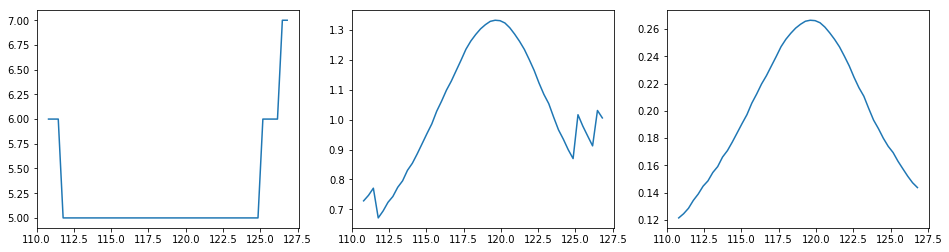

Angle = 28.8


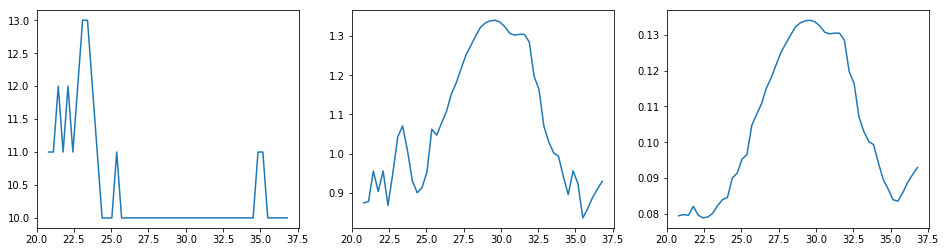

In [23]:
# Plot results. 
# Number of maxima, total intensity of maxima, and score (inten/#) function

scores = total_intensity/N_maxima

for i in range(len(angle_guesses)):
    
    print("Angle = {}".format(angle_guesses[i]))
    angles = np.linspace(angle_guesses[i]-window_rad_degrees,angle_guesses[i]+window_rad_degrees,N_rotations)
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(16,4))
    ax1.plot(angles,N_maxima[:,i])
    ax2.plot(angles,total_intensity[:,i])
    ax3.plot(angles,scores[:,i])
    plt.show()

In [24]:
# Get maxima of scores

sigma = 2
min_diff = 5

scores = total_intensity/N_maxima

scores_blurred = np.empty_like(scores)

coordinates = [('angle',float),('intensity',float)]
refined_score_maxima = [PointList(coordinates, dc), PointList(coordinates, dc)]

for j in range(len(angle_guesses)):

    angle_guess = angle_guesses[j]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)
    
    scores_blurred[:,j] = gaussian_filter(scores[:,j],sigma)
    
    refined_score_maxima0 = (scores_blurred[:,j] > np.roll(scores_blurred[:,j],-1)) & (scores_blurred[:,j] >= np.roll(scores_blurred[:,j],+1))
    
    for i in refined_score_maxima0.nonzero()[0]:
        new_point = (angles[i], scores_blurred[i,j])
        refined_score_maxima[j].add_point(new_point)
    
    refined_score_maxima[j].sort('intensity')
    
    deletemask = np.zeros(refined_score_maxima[j].length,dtype=bool)
    for i in range(refined_score_maxima[j].length):
        if not deletemask[i]:
            delete = np.abs(refined_score_maxima[j].data['angle'][i]-refined_score_maxima[j].data['angle']) < min_diff
            delete[:i+1]=False
            deletemask = deletemask | delete
    refined_score_maxima[j].remove_points(deletemask)

Angle = 118.8


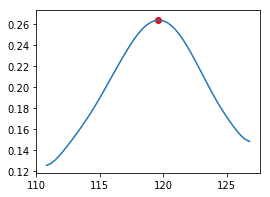

Angle = 28.8


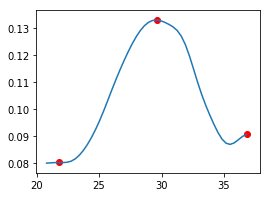

In [25]:
# Plot score and maxima

for j in range(len(angle_guesses)):

    angle_guess = angle_guesses[j]
    angles = np.linspace(angle_guess-window_rad_degrees,angle_guess+window_rad_degrees,N_rotations)

    print("Angle = {}".format(angle_guess))
    fig,ax = plt.subplots(figsize=(4,3))
    ax.plot(angles, scores_blurred[:,j])
    ax.scatter(refined_score_maxima[j].data['angle'],refined_score_maxima[j].data['intensity'],color='r')
    plt.show()

In [26]:
# Get u and v angles

refined_score_maxima[0].sort('intensity')
refined_score_maxima[1].sort('intensity')
u_angle = refined_score_maxima[0].data['angle'][0]
v_angle = refined_score_maxima[1].data['angle'][0]

print("u and v angles are {} and {} degrees, respectively.".format(u_angle, v_angle))

u and v angles are 119.61632653061224 and 29.61632653061224 degrees, respectively.


### Get lattice vector lengths

In [27]:
# Parameters

sigma_gaussianblur = 10
min_dist = 10
threshhold = 0.05

coordinates = [('bin',float),('intensity',float)]
u_maxima = PointList(coordinates, dc)
v_maxima = PointList(coordinates, dc)

In [28]:
# Get peaks when projecting down u

Bragg_peaks_rotating = Bragg_peaks_current_DP.copy()
theta = u_angle*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)
for i in range(Bragg_peaks_rotating.length):
    x0 = Bragg_peaks_rotating.data['qx'][i]
    y0 = Bragg_peaks_rotating.data['qy'][i]
    Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
# Get projected histogram
bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
projected_histogram = np.zeros_like(bins)
for i in range(Bragg_peaks_rotating.length):
    projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1

histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)

# Get maxima
maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))

for i in maxima0.nonzero()[0]:
    new_point = (bins[i], histogram_blurred[i])
    u_maxima.add_point(new_point)

u_maxima.sort('intensity')

# Remove maxima below threshhold
max_intensity = u_maxima.data['intensity'][0]
deletemask = np.zeros(u_maxima.length,dtype=bool)
for i in range(u_maxima.length):
    if u_maxima.data['intensity'][i]/max_intensity < threshhold:
        deletemask[i] = True
u_maxima.remove_points(deletemask)

# Remove maxima which are too close together
deletemask = np.zeros(u_maxima.length,dtype=bool)
for i in range(u_maxima.length):
    if not deletemask[i]:
        delete = np.abs(u_maxima.data['bin'][i]-u_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
u_maxima.remove_points(deletemask)

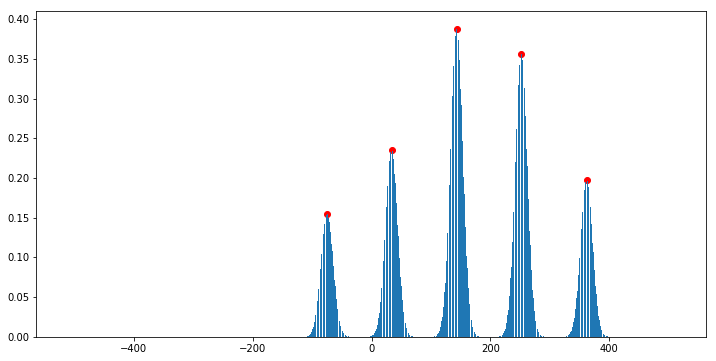

In [29]:
# Plot histograms

fig,ax = plt.subplots(figsize=(12,6))
ax.bar(bins, histogram_blurred)
ax.scatter(u_maxima.data['bin'],u_maxima.data['intensity'],color='r')
plt.show()

In [30]:
# Get u projected spacing

thresh=1.5

u_maxima.sort('bin')
diffs = u_maxima.data['bin'][:-1]-u_maxima.data['bin'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
u_projected_spacing = np.average(diffs)

In [31]:
# Get peaks when projecting down v

Bragg_peaks_rotating = Bragg_peaks_current_DP.copy()
theta = v_angle*np.pi/180.
costheta = np.cos(theta)
sintheta = np.sin(theta)
for i in range(Bragg_peaks_rotating.length):
    x0 = Bragg_peaks_rotating.data['qx'][i]
    y0 = Bragg_peaks_rotating.data['qy'][i]
    Bragg_peaks_rotating.data['qx'][i] = x0*costheta - y0*sintheta
    Bragg_peaks_rotating.data['qy'][i] = x0*sintheta + y0*costheta
    
# Get projected histogram
bins = np.arange(-dc.Q_Nx,dc.Q_Nx)
projected_histogram = np.zeros_like(bins)
for i in range(Bragg_peaks_rotating.length):
    projected_histogram[int(Bragg_peaks_rotating.data['qx'][i])] += 1

histogram_blurred = gaussian_filter(projected_histogram.astype(float),sigma_gaussianblur)

# Get maxima
maxima0 = (histogram_blurred > np.roll(histogram_blurred,-1)) & (histogram_blurred >= np.roll(histogram_blurred,+1))

for i in maxima0.nonzero()[0]:
    new_point = (bins[i], histogram_blurred[i])
    v_maxima.add_point(new_point)

v_maxima.sort('intensity')

# Remove maxima below threshhold
max_intensity = v_maxima.data['intensity'][0]
deletemask = np.zeros(v_maxima.length,dtype=bool)
for i in range(v_maxima.length):
    if v_maxima.data['intensity'][i]/max_intensity < threshhold:
        deletemask[i] = True
v_maxima.remove_points(deletemask)

# Remove maxima which are too close together
deletemask = np.zeros(v_maxima.length,dtype=bool)
for i in range(v_maxima.length):
    if not deletemask[i]:
        delete = np.abs(v_maxima.data['bin'][i]-v_maxima.data['bin']) < min_dist
        delete[:i+1]=False
        deletemask = deletemask | delete
v_maxima.remove_points(deletemask)

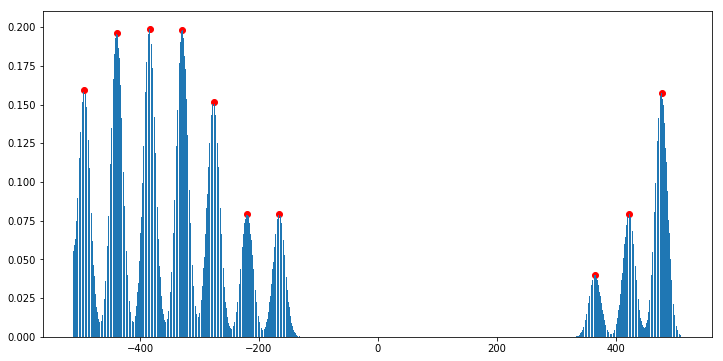

In [32]:
# Plot histograms

fig,ax = plt.subplots(figsize=(12,6))
ax.bar(bins, histogram_blurred)
ax.scatter(v_maxima.data['bin'],v_maxima.data['intensity'],color='r')
plt.show()

In [33]:
# Get v spacing

thresh = 1.5

v_maxima.sort('bin')
diffs = v_maxima.data['bin'][:-1]-v_maxima.data['bin'][1:]
mask = np.array([max(i,np.median(diffs))/min(i,np.median(diffs)) for i in diffs]) < thresh
diffs = diffs[mask]
v_projected_spacing = np.average(diffs)

In [34]:
# Get u and v lengths

sin_uv = np.sin(np.abs(u_angle-v_angle)*np.pi/180.)
u_length = v_projected_spacing / sin_uv
v_length = u_projected_spacing / sin_uv

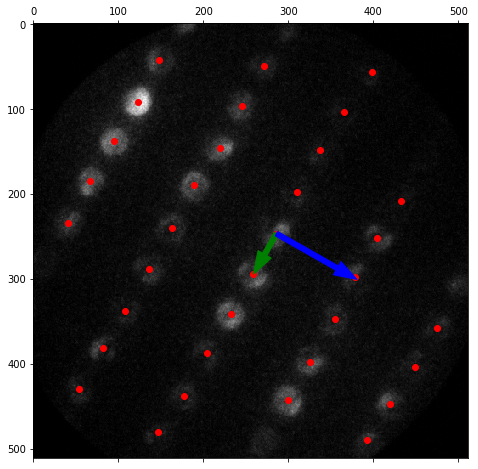

In [35]:
# Show

ind = np.argmin((Bragg_peaks_current_DP.data['qx']-dc.Q_Nx/2)**2 + (Bragg_peaks_current_DP.data['qy']-dc.Q_Ny/2)**2)
x0,y0 = Bragg_peaks_current_DP.data['qx'][ind],Bragg_peaks_current_DP.data['qy'][ind]

u_dx = np.cos(u_angle*np.pi/180.)*u_length
u_dy = np.sin(u_angle*np.pi/180.)*u_length
v_dx = np.cos(v_angle*np.pi/180.)*v_length
v_dy = np.sin(v_angle*np.pi/180.)*v_length

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(DP)
ax.scatter(Bragg_peaks_current_DP.data['qy'],Bragg_peaks_current_DP.data['qx'],color='r')
ax.arrow(y0,x0,u_dx,u_dy, color='green',width=6,length_includes_head=True)
ax.arrow(y0,x0,v_dx,v_dy, color='blue',width=6,length_includes_head=True)
plt.show()

### Save lattice vectors

In [36]:
# Make pointlist

coordinates = [('angle',float),('length',float)]
lattice_vectors = PointList(coordinates, dc, name='lattice_vectors')
lattice_vectors.add_point((u_angle,u_length))
lattice_vectors.add_point((v_angle,v_length))

In [40]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
py4DSTEM.readwrite.save_dataobject(lattice_vectors,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5...
Writing metadata...
Done.


In [39]:
# Save

savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/lattice_vectors.h5"
py4DSTEM.readwrite.save_dataobject(lattice_vectors,savepath)